# 03b Validate CATE estimators TC (cfd_cardio)

In this notebook, we will try to validate CATE estimators with respect to the GI outcome.

### Contents:
1. Set up
2. Calibration and R2  
2.1. Calibration plots for a fixed data split  
2.2. CR2 generalization scatter plots  
2.3. Aggregate R2 statistics. 
3. Monotonicity  
3.1. Monotinicity with respect to 5 bins  
3.2. Comparing quantile-based top subgroup with its complement  
4. Stability of CATE estimators  
4.1. Stability of quantile-based top subgroup  
4.2. Overlaps of quantile-based subgroups  
4.3. Aggregate correlation statistics  
4.4. Pairwise correlation for a single estimator when trained on different splits

## 1. Set up

In [1]:
# Standard imports
import numpy as np
import pandas as pd
from scipy import stats
import sys
import copy
import random
import joblib

# Plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import matplotlib as mpl
import pylab

# Import sklearn methods
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Lasso, LogisticRegression
from sklearn.model_selection import StratifiedKFold

# Import own methods
from methods.data_processing import prepare_df, separate_vars
from methods.cate_estimator_validation import \
            (make_estimator_library, fit_estimator_libraries, 
             get_calibration_plot_data, get_cr2_plot_data, 
             get_calibration_score, get_cr2_score, get_r_values, 
             get_overlap_values, get_monotonicity_results, 
             combine_estimator_versions, get_top_subgroup_stability)

The sklearn.utils.testing module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.utils. Anything that cannot be imported from sklearn.utils is now part of the private API.


In [2]:
# Globals
BASEDIR = "/home/ubuntu/vioxx_vigor/"
DATA_PATH = BASEDIR + "data/01_transformed/20jul2020/"
original_features = ["male", "white", "US", "PUB_PRIOR_HISTORY", 'elderly_65_adj',
            "HYPGRP", "DBTGRP", "CHLGRP", "ASPFDA", "ASCGRP", 'obese',
            "PSTRDS", "PNSAIDS", "PNAPRXN", "smoker", "drinker"]
n_splits = 4
q_values = np.array([0.5, 0.4, 0.3, 0.2, 0.1])

base_learners = {"lasso" : Lasso(),
                 "logistic" : LogisticRegression(solver = "liblinear", 
                                                 max_iter = 500),
                 "rf" : RandomForestRegressor(),
                 "xgb" : XGBRegressor(objective = "reg:squarederror")}

outcome_name = "cfd_cardio"
alternate_outcome = "all_cardio"
dir_neg = False
ATE = 0.00566
n_bins = 5

In [3]:
# Global plot style settings
plt.style.use("fivethirtyeight")
mpl.rcParams['lines.markersize'] = 10
mpl.rcParams['grid.linewidth'] = 2.5
mpl.rcParams['legend.fontsize'] = 20
pylab.rcParams['xtick.major.pad'] = 5
pylab.rcParams['ytick.major.pad'] = 5
mpl.rcParams["figure.figsize"] = [8, 6]
mpl.rcParams['savefig.transparent'] = True
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['figure.edgecolor'] = 'black'
# plt.rcParams['patch.edgecolor'] = 'white'
plt.rcParams['axes.facecolor'] = 'white'
# plt.rcParams['grid.color'] = 'black'
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

label_size = 25
mpl.rcParams['xtick.labelsize'] = label_size 
mpl.rcParams['ytick.labelsize'] = label_size 
mpl.rcParams['axes.labelsize'] = label_size
mpl.rcParams['axes.titlesize'] = label_size
mpl.rcParams['figure.titlesize'] = label_size

# Save settings
SAVE_PATH  = f"figs/{outcome_name}/"
savfig = True

If estimators are already cached, load them instead of running 1.1.

In [4]:
# Load the fitted libraries
fitted_libraries = joblib.load(f"data_files/{outcome_name}/{outcome_name}_fitted_libraries")

### 1.1. Fit estimators in the library

In [3]:
tuned_params = joblib.load(f"data_files/{outcome_name}/{outcome_name}_tuned_params")

fitted_libraries = fit_estimator_libraries(DATA_PATH, original_features, outcome_name, 
                                           base_learners, tuned_params, n_splits, 
                                           perturbed = True, num_cv_splits = 2, 
                                           alternate_outcome = alternate_outcome)

100%|██████████| 18/18 [01:04<00:00,  3.56s/it]


In [4]:
# Dump the fitted libraries
joblib.dump(fitted_libraries, f"data_files/{outcome_name}/{outcome_name}_fitted_libraries")

['data_files/cfd_cardio/cfd_cardio_fitted_libraries']

## 2. Calibration and R2 (predictability)

### 2.1. Calibration plots for a fixed data split

In [5]:
selected_estimators = ["s_rf", "t_rf", "x_rf", "r_rfrf", "causal_forest_1"]
new_labels = ["T_RF", "S_RF", "X_RF","R_RFRF", "CF_1"]
new_labels = ["t_rf", "s_rf", "x_rf","r_rfrf", "cf"]
new_labels_dict = dict(zip(selected_estimators, new_labels))

fold_no = 0 

In [6]:
# Get data to make plot
val_plots_data = {}
train_plots_data = {}
for estimator in selected_estimators:
    val_plots_data[estimator] = get_calibration_plot_data(fitted_libraries["pert_none"][estimator], 
                                                     fold_no, n_bins)
    train_plots_data[estimator] = get_calibration_plot_data(fitted_libraries["pert_none"][estimator], 
                                                       fold_no, n_bins, kind = "train")
cal_plot_data = [train_plots_data, val_plots_data]
joblib.dump(cal_plot_data, f"data_files/{outcome_name}/{outcome_name}_calplotdata")

In [7]:
label_size = 35
mpl.rcParams['xtick.labelsize'] = label_size 
mpl.rcParams['ytick.labelsize'] = 35
mpl.rcParams['axes.labelsize'] = label_size
mpl.rcParams['axes.titlesize'] = label_size
mpl.rcParams['figure.titlesize'] = label_size

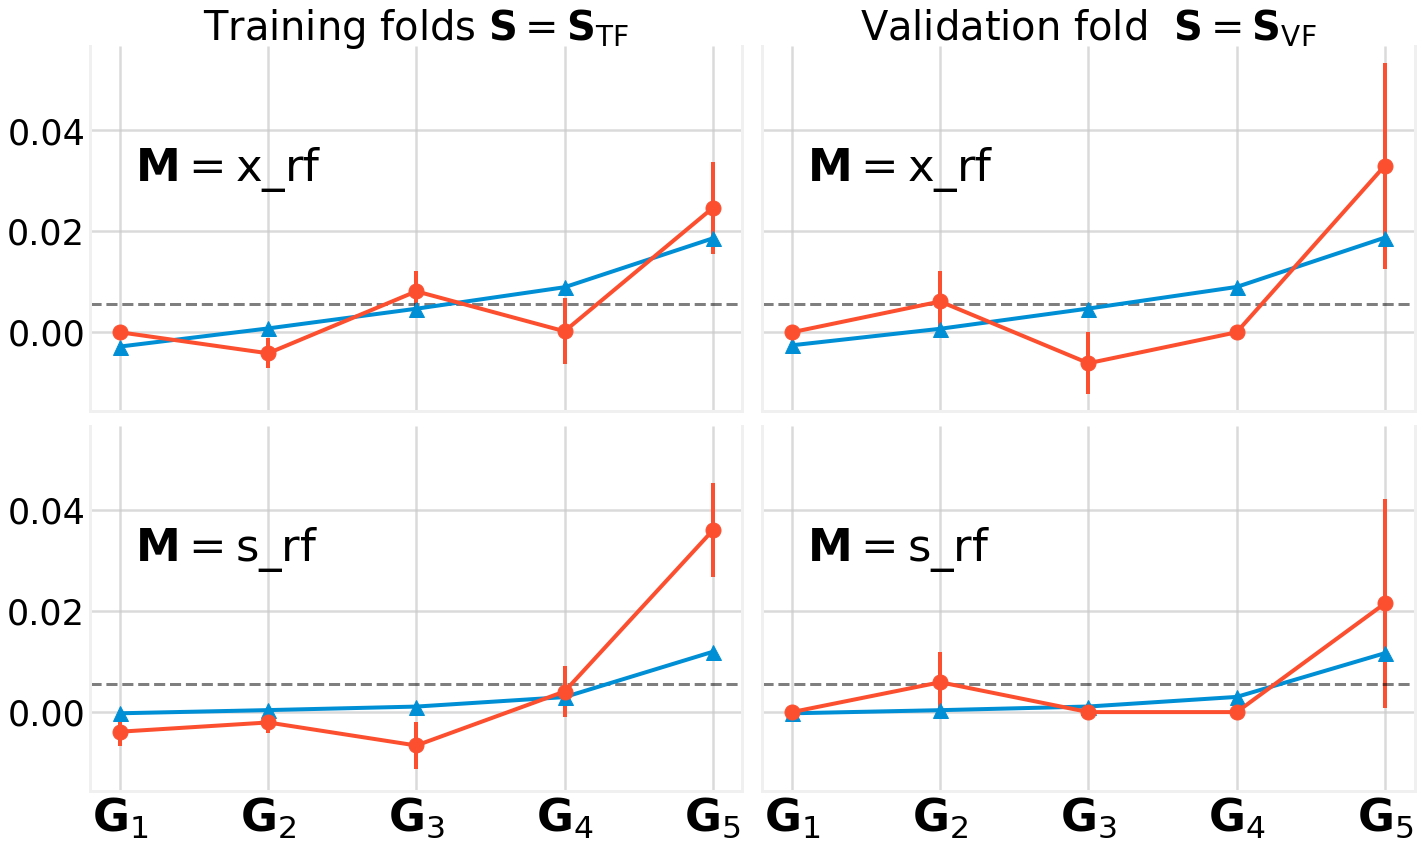

In [8]:
xticks = ['[0.,.2]', '[.2,.4]', '[.4,.6]', '[.6,.8]', '[.8,1]']
xticks = [r'$\mathbf{G}_%d$'%j for j in range(1,6)]
fig, axes = plt.subplots(2, 2, sharey = True, sharex=True, figsize = [20, 12])
axes = axes.flatten()
for j, estimator in enumerate(['x_rf', 's_rf']):
    ax1, ax2 = axes[2*j], axes[2*j+1]
    for k, (lab, title, ax) in enumerate(zip(["train", "val"], 
                                             [r"Training folds $\mathbf{S} = \mathbf{S}_{\mathrm{TF}}$", 
                                              "Validation fold  $\mathbf{S} = \mathbf{S}_{\mathrm{VF}}$"], 
                                             [ax1 ,ax2])):
        if j == 0:
            ax.set_title(title, fontsize=40)
        # Plot model CATEs
        p1 = ax.errorbar(x = np.arange(0, n_bins), 
                    y = cal_plot_data[k][estimator]["model_CATEs"], 
                    yerr = cal_plot_data[k][estimator]["model_CATEs_std"],
                    marker= '^', markersize = 15, #color = "red",
                    linewidth = 4., 
                    )
        # Plot Neyman CATEs
        p2 = ax.errorbar(x = np.arange(0, n_bins), 
                    y = cal_plot_data[k][estimator]["Neyman_CATEs"],
                    yerr = cal_plot_data[k][estimator]["Neyman_CATEs_std"],
                    marker = 'o', markersize = 15, #color = "blue",
                    linewidth = 4., 
                    )
        ax.text(x=0.1, y=0.03, s= r'$\mathbf{M}=$' + estimator, fontsize=45)
        # Add line to indicate ATE
        ax.axhline(y = ATE, linestyle='--', color = 'k', linewidth = 3., alpha = 0.5)
        # X labels and legend
        if j == 1:
            ax.set_xticks(np.arange(0, n_bins))
#             ax.set_xticklabels(cal_plot_data[k][estimator].index)
            ax.set_xticklabels(xticks, fontsize=45)
#             ax.set_xlabel(r"q value range for $\mathcal{G}$")

            
        ax.grid(True, alpha = 0.7)
#         ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
#         ax.spines['bottom'].set_visible(False)
# plt.suptitle("TC Events", y=1.01)
plt.tight_layout()
leg = fig.legend((p1, p2), (r'$\overline{\mathbf{M}}_{\mathbf {G} \cap \mathbf{S}}$', 
                            r'$\widehat{\tau}_{\mathbf{G}\cap \mathbf{S}}$'), 'center right', 
                 bbox_to_anchor=(0.45, 0.48), fontsize=45,
                 frameon=True)

savfig = False
if savfig:
    plt.savefig(SAVE_PATH + f"{outcome_name}_x_rf_s_rf_calibration_plot.pdf"
                , bbox_inches='tight'
               )
leg.remove()

if savfig:
    plt.savefig(SAVE_PATH + f"{outcome_name}_x_rf_s_rf_calibration_plot_no_leg.pdf"
                , bbox_inches='tight'
               )

plt.show()

### 2.2. CR2 generalization scatter plots

Refer to `06_plots` for the plots. Here we just generate the data necessary for the plots.

In [8]:
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
# colors: ['#008fd5', '#fc4f30', '#e5ae38', '#6d904f', '#8b8b8b', '#810f7c']
# colors = ['red', 'blue', 'green', 'black', 'cyan', 'magenta', 'yellow']
lss = ['--', '-.', ':', '-']
mss = ['>', 's', 'o', 'D', '^']
mss = ['X', 'o', '*', 'D', '+']
ms_size = [25, 20, 30, 20, 25]

In [9]:
# Get data to make plot
cr2_5r_plot_data = {}
for estimator in selected_estimators:
    cr2_5r_plot_data[estimator] = \
            get_cr2_plot_data(fitted_libraries["pert_none"][estimator],
                              n_bins, n_bins_selected = n_bins, 
                              dir_neg = dir_neg)
    
cr2_2r_plot_data = {}
for estimator in selected_estimators:
    cr2_2r_plot_data[estimator] = \
            get_cr2_plot_data(fitted_libraries["pert_none"][estimator], 
                              n_bins, n_bins_selected = 2, 
                              dir_neg = dir_neg)

In [48]:
joblib.dump([cr2_5r_plot_data, cr2_2r_plot_data], f"data_files/{outcome_name}/{outcome_name}_rscores")

['data_files/cfd_cardio/cfd_cardio_rscores']






### 2.3. Aggregate R2 statistics

Refer to `06_plots` for the histogram plot where we aggregate over all estimators.

In [9]:
# Get data to make plot
all_estimators = list(fitted_libraries["pert_none"].keys())

cr2_plot_data = {}
for estimator in all_estimators:
    cr2_plot_data[estimator] = get_cr2_plot_data(fitted_libraries["pert_none"][estimator], 
                                                 n_bins)
    cr2_plot_data[estimator] = pd.concat([cr2_plot_data[estimator],
                            get_cr2_plot_data(fitted_libraries["pert_cv_0"][estimator], 
                                              n_bins)])
    cr2_plot_data[estimator] = pd.concat([cr2_plot_data[estimator],
                            get_cr2_plot_data(fitted_libraries["pert_cv_1"][estimator], 
                                              n_bins)])
    cr2_plot_data[estimator] = cr2_plot_data[estimator].reset_index() \
                                                       .drop(columns = ["index"])

for estimator in all_estimators:
    cr2_plot_data[estimator] = cr2_plot_data[estimator].reset_index() \
                                                       .drop(columns = ["index"])
all_cr2_scores_val = pd.concat(cr2_plot_data[estimator]["cr2_val"] 
                               for estimator in all_estimators)

all_cr2_scores_train = pd.concat(cr2_plot_data[estimator]["cr2_train"] 
                               for estimator in all_estimators)

Mean of empty slice.
invalid value encountered in double_scalars
Mean of empty slice.


In [54]:
joblib.dump([all_cr2_scores_train, all_cr2_scores_val], f"data_files/{outcome_name}/{outcome_name}_rscores_hist")

['data_files/cfd_cardio/cfd_cardio_rscores_hist']

In [26]:
all_estimators = np.array(all_estimators)
estimator_argsort = np.argsort([-cr2_plot_data[estimator]["cr2_val"].mean() 
                                for estimator in all_estimators])
all_estimators = all_estimators[estimator_argsort]

All-NaN slice encountered
All-NaN slice encountered


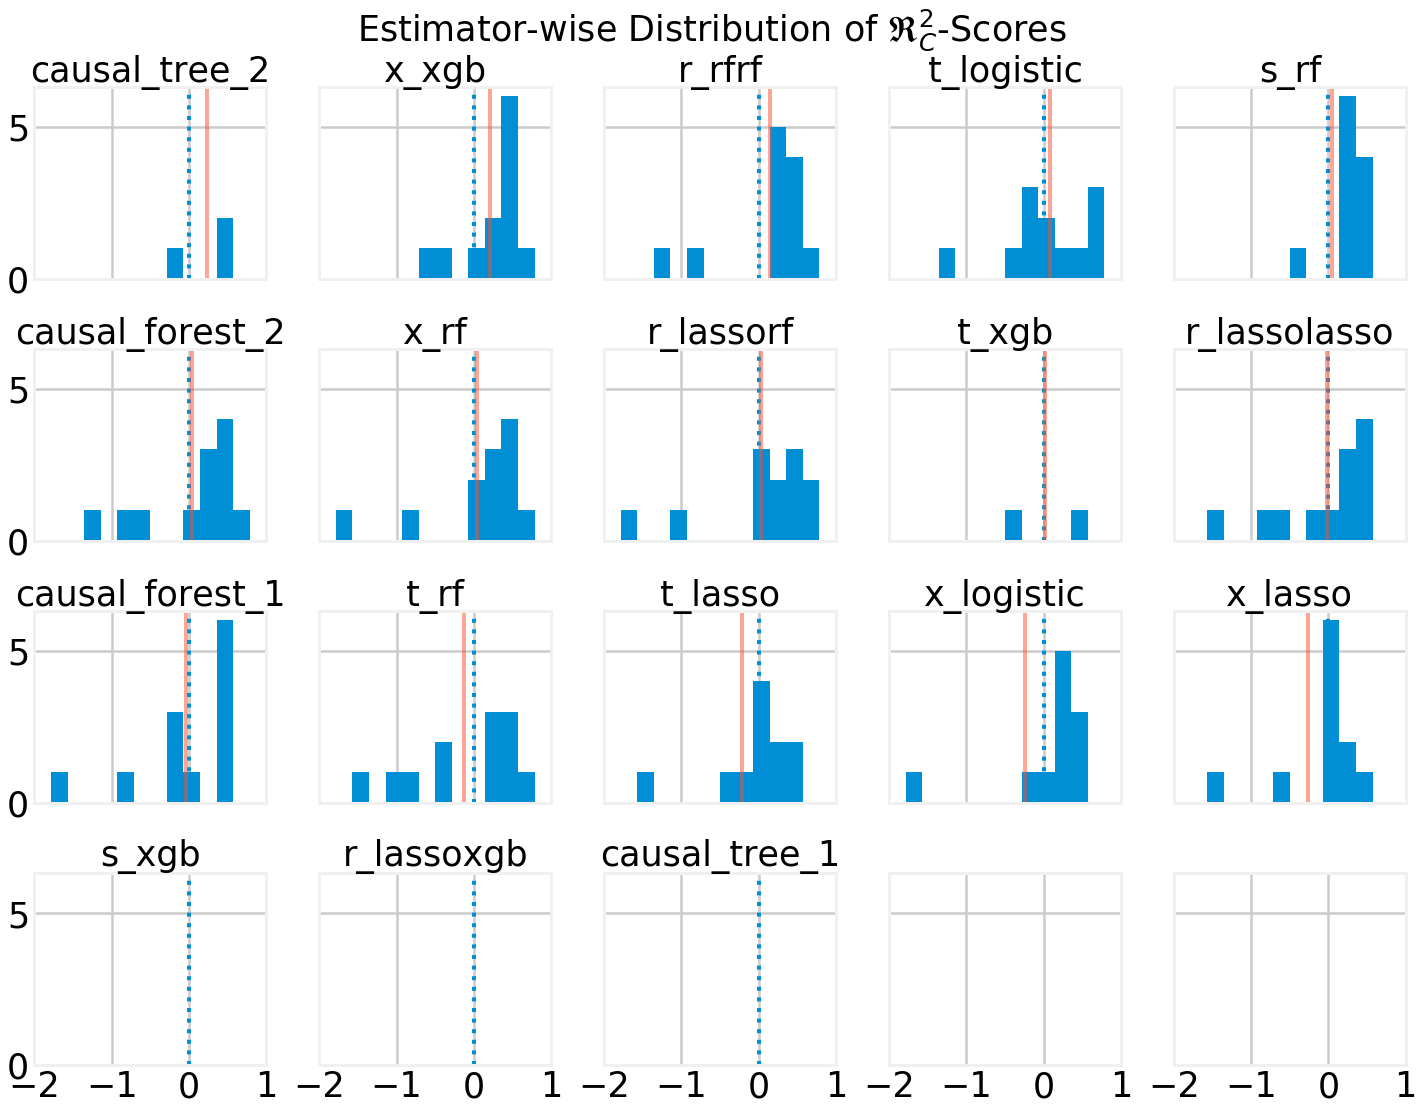

In [27]:
f, axes = plt.subplots(4, 5, figsize=[20, 15], sharex = True, sharey = True)
axes = axes.flatten()
for i, estimator in enumerate(all_estimators):
    ax = axes[i]
    ax.hist(cr2_plot_data[estimator]["cr2_val"], bins = np.linspace(-2,1,15))
    ax.axvline(0, alpha=1., linestyle=':')
    ax.axvline(cr2_plot_data[estimator]["cr2_val"].mean(), linestyle='-', 
               color=colors[1], alpha=0.5)
    ax.set_title(estimator)
    ax.set_xticks([-2, -1, 0, 1.])
    plt.xlim([-2, 1])
plt.tight_layout()
plt.suptitle(r"Estimator-wise Distribution of $\mathfrak{R}_C^2$-Scores", y = 1.03)
plt.show()

In [29]:
bad_estimators = ["r_lassoxgb", "causal_tree_1", "s_xgb"]

Takeaways: Poor prediction performance
1. Calibration plots show that the validation set is too small to accurately gauge prediction accuracy of CATE estimators.  
2. $C-R^2$ scatter plots show further evidence of overfitting. (training scores are systematically higher than validation scores).   
3. $C-R^2$ histograms show that across all estimators and 12 different training-validation data splits, the overwhelming majority of scores is less than 0.5,  
i.e. only reduces l1-variability by 50% from the ATE constant predictor baseline.

## 3. Monotonicity

- Top estimators are computed in 04b
- Refer to `06_plots` for the monotonicity boxplot

In [30]:
top_estimator_names = joblib.load(f"data_files/{outcome_name}/{outcome_name}_top_estimator_names")
print(outcome_name,top_estimator_names, bad_estimators)

cfd_cardio ['s_rf', 't_lasso', 't_rf', 'x_xgb', 't_logistic'] ['r_lassoxgb', 'causal_tree_1', 's_xgb']


### 3.1. Monotinicity with respect to 5 bins  

In [31]:
dropped_estimators = bad_estimators
monotonicity_df = get_monotonicity_results(fitted_libraries, top_estimator_names=top_estimator_names, 
                                           n_bins = 5, dir_neg = dir_neg, 
                                           dropped_estimators = dropped_estimators)

Mean of empty slice.
invalid value encountered in double_scalars
invalid value encountered in greater


In [32]:
monotonicity_df.round(2)

,"[0.0,0.2] vs [0.2, 0.4]","[0.2,0.4] vs [0.4, 0.6]","[0.4,0.6] vs [0.6, 0.8]","[0.6,0.8] vs [0.8, 1.0]",last_bin_is_max
s_rf,0.42,0.42,0.42,0.92,0.83
t_lasso,0.33,0.42,0.42,1.00,1.00
t_logistic,0.33,0.25,0.58,0.83,0.75
t_rf,0.33,0.25,0.67,0.83,0.75
t_xgb,0.08,0.08,0.25,0.75,0.08
x_lasso,0.50,0.33,0.50,0.83,0.75
x_logistic,0.50,0.50,0.42,0.92,0.92
x_rf,0.50,0.33,0.58,0.83,0.75
x_xgb,0.33,0.50,0.58,0.92,0.92
r_lassolasso,0.17,0.75,0.50,0.75,0.67


In [71]:
joblib.dump(monotonicity_df, f"data_files/{outcome_name}/{outcome_name}_monotonicity_df")

['data_files/cfd_cardio/cfd_cardio_monotonicity_df']

In [10]:
# Run this cell to get latex code for the table
#mon_table = monotonicity_df.sort_values('last_bin_is_max', ascending=False).round(2).to_latex()
#print(mon_table)

### 3.2. Comparing quantile-based top subgroup with its complement

In [35]:
new_monotonicity_df = get_monotonicity_results(fitted_libraries, top_estimator_names = top_estimator_names,
                                               q_values = [0.1, 0.2, 0.3, 0.4, 0.5], dir_neg = False, 
                                               dropped_estimators = dropped_estimators)

In [36]:
new_monotonicity_df.round(2)

,"[0.0,0.9] vs [0.9, 1.]","[0.0,0.8] vs [0.8, 1.]","[0.0,0.7] vs [0.7, 1.]","[0.0,0.6] vs [0.6, 1.]","[0.0,0.5] vs [0.5, 1.]"
s_rf,0.83,1.00,1.00,0.83,0.75
t_lasso,0.92,1.00,0.92,0.92,0.92
t_logistic,1.00,0.92,0.92,0.92,0.92
t_rf,0.92,0.92,1.00,0.92,0.92
t_xgb,0.92,0.83,0.83,0.92,1.00
x_lasso,0.92,0.92,1.00,0.92,0.92
x_logistic,0.92,0.92,0.92,0.92,0.92
x_rf,0.92,0.92,0.92,1.00,0.92
x_xgb,0.92,0.92,0.92,0.92,0.92
r_lassolasso,0.92,0.92,0.92,0.92,0.83


In [37]:
joblib.dump(new_monotonicity_df, f"data_files/{outcome_name}/{outcome_name}_new_monotonicity_df")

['data_files/cfd_cardio/cfd_cardio_new_monotonicity_df']

## 4. Stability of CATE estimators

### 4.1. Stability of quantile-based top subgroup

In this section, we examine the stability of the quantile-based subgroups by generalizing the notion of overlap.  
We consider the quantile-based top subgroup for q=0.2, and compute what percentage of its members are contained  
in the quantile-based top subgroup for other values of q, when the two subgroups are obtained from CATE estimators  
trained on different data splits.

In [39]:
library_names = ["pert_none", "pert_cv_0", "pert_cv_1"]
library = {}
for estimator_name in fitted_libraries["pert_none"].keys():
    list_of_estimators = []
    for library_name in library_names:
        list_of_estimators.append(fitted_libraries[library_name][estimator_name])
    library[estimator_name] = combine_estimator_versions(list_of_estimators)
stability_scores = {}
q0 = 0.2
q_values_v2 = [0.2, 0.3, 0.4, 0.5]
for estimator_name, estimator in library.items():
    stability_scores[estimator_name] = get_top_subgroup_stability(estimator, q0, q_values_v2, dir_neg).round(2)

invalid value encountered in true_divide
divide by zero encountered in true_divide
invalid value encountered in subtract


In [40]:
same_q_scores = []
diff_q_scores = []
for scores in stability_scores.values():
    same_q_scores.append(scores.loc[0.2,"mean coverage"])
    diff_q_scores.append(scores.loc[0.3,"mean coverage"])
scores_df = pd.DataFrame({"estimator" : list(stability_scores.keys()),
                          "0.2" : same_q_scores,
                          "0.3" : diff_q_scores})
scores_df = scores_df.set_index("estimator")
scores_df.drop(index = ["r_lassoxgb"], inplace = True)

In [41]:
scores_df

,0.2,0.3
estimator,,
s_rf,0.71,0.84
s_xgb,NaN,inf
t_lasso,0.75,0.89
t_logistic,0.77,0.90
t_rf,0.69,0.83
t_xgb,0.67,0.98
x_lasso,0.71,0.85
x_logistic,0.73,0.88
x_rf,0.70,0.84


### 4.2. Overlaps of quantile-based subgroups

In [65]:
dropped_estimators = ['r_lassoxgb', 'causal_tree_1', "causal_tree_2", 's_xgb', "t_xgb"]
all_overlaps = get_overlap_values(fitted_libraries, 0.8, 1, compare_across = "all", 
                                  dropped_estimators = dropped_estimators)

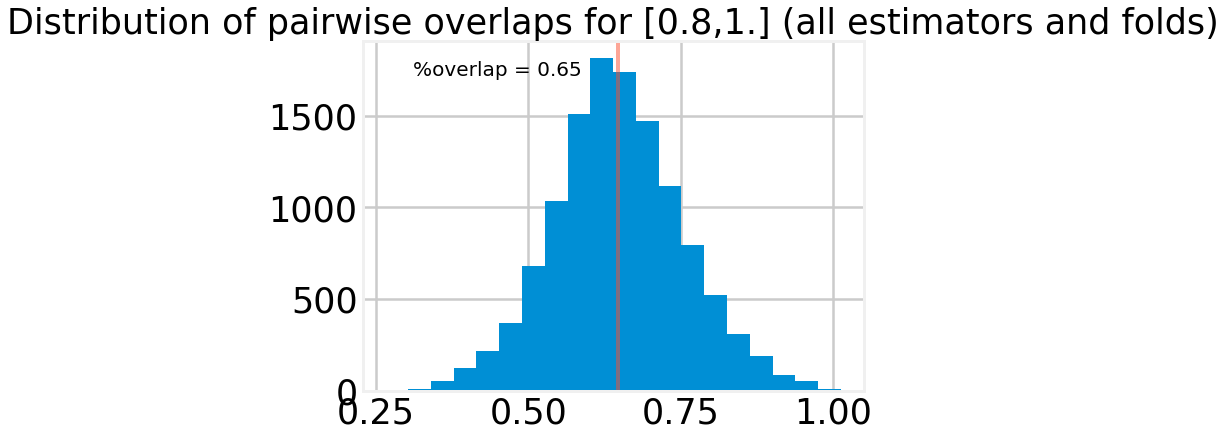

In [75]:
plt.hist(all_overlaps, bins = 20, zorder = 1)
plt.title("Distribution of pairwise overlaps for [0.8,1.] (all estimators and folds)")
mean_overlap = all_overlaps.mean()
plt.axvline(x = mean_overlap, linestyle='-', color=colors[1], alpha=0.5, zorder = 2)
ax = plt.gca()
plt.annotate("%overlap = {:.2f}".format(mean_overlap),
             xy = (0.1, 0.9), xycoords = ax.transAxes,
             fontsize = 20)
plt.show()

In [67]:
estimator_overlaps = get_overlap_values(fitted_libraries, 0.8, 1, compare_across = "estimators",
                                        fold = 0, dropped_estimators = dropped_estimators)

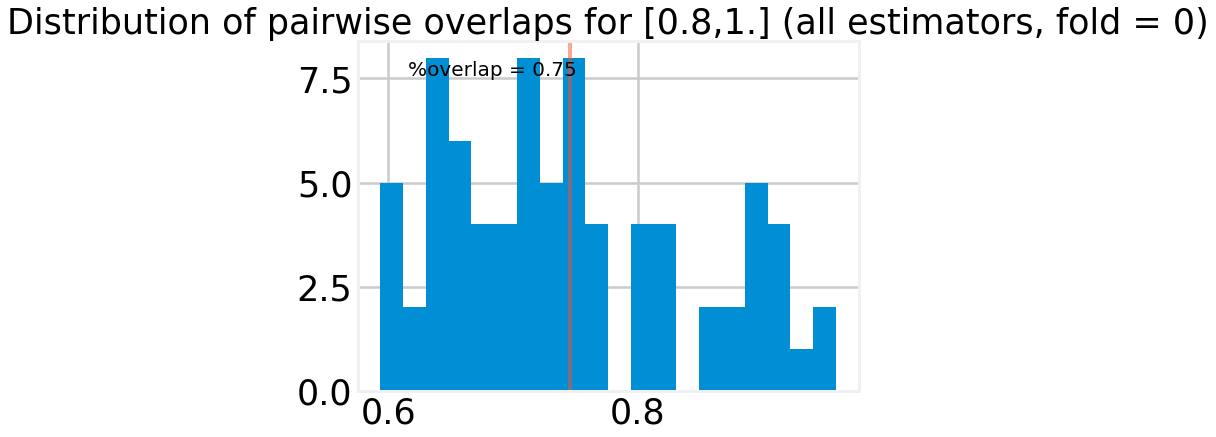

In [74]:
plt.hist(estimator_overlaps, bins = 20, zorder = 1)
plt.title("Distribution of pairwise overlaps for [0.8,1.] (all estimators, fold = 0)")
mean_overlap = estimator_overlaps.mean()
plt.axvline(x = mean_overlap, linestyle='-', color=colors[1], alpha=0.5, zorder = 2)
ax = plt.gca()
plt.annotate("%overlap = {:.2f}".format(mean_overlap),
             xy = (0.1, 0.9), xycoords = ax.transAxes,
             fontsize = 20)
plt.show()

In [79]:
# Get data to make plot
selected_estimators = list(fitted_libraries["pert_none"].keys())
for estimator in dropped_estimators:
    selected_estimators.remove(estimator)
overlap_plot_data = {}
for estimator in selected_estimators:
    overlap_plot_data[estimator] = get_overlap_values(fitted_libraries, 0.8, 1,
                                                      compare_across = "folds",
                                                      estimator = estimator)
# Order the estimators in decreasing order w.r.t. mean overlap
selected_estimators = np.array(selected_estimators)
estimator_argsort = np.argsort([-overlap_plot_data[estimator].mean() for estimator in selected_estimators])
selected_estimators = selected_estimators[estimator_argsort]

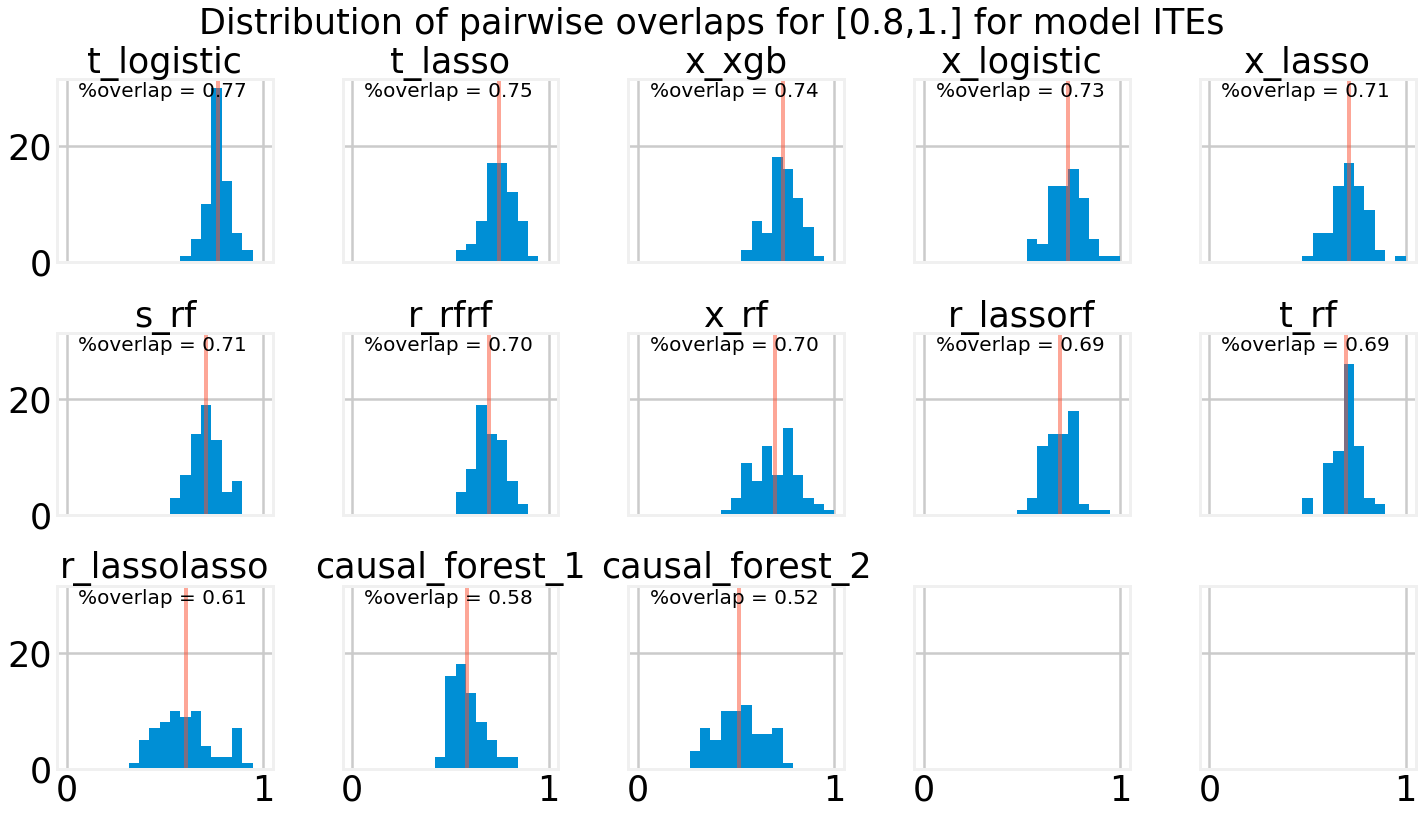

In [76]:
f, axes = plt.subplots(3, 5, figsize=[20, 11], sharex = True, sharey = True)
axes = axes.flatten()
for i, estimator in enumerate(selected_estimators):
    ax = axes[i]
    ax.hist(overlap_plot_data[estimator], bins = np.linspace(0, 1, 20))
    mean_overlap = overlap_plot_data[estimator].mean()
    ax.axvline(mean_overlap, linestyle='-', color=colors[1], alpha=0.5)
    ax.annotate("%overlap = {:.2f}".format(mean_overlap),
                xy = (.1, .9), xycoords = ax.transAxes,
                fontsize = 20)
    ax.set_title(estimator)
#    ax.set_xticks([-2, -1, 0, 1.])
#    plt.xlim([-2, 1])
plt.tight_layout()
plt.suptitle("Distribution of pairwise overlaps for [0.8,1.] for model ITEs", y = 1.03)
plt.show()

In [80]:
# Get data to make plot
overlap_plot_data = {}
for estimator in selected_estimators:
    overlap_plot_data[estimator] = get_overlap_values(fitted_libraries, 0.6, 0.8,
                                                      compare_across = "folds",
                                                      estimator = estimator)
# Order the estimators in decreasing order w.r.t. mean overlap
selected_estimators = np.array(selected_estimators)
estimator_argsort = np.argsort([-overlap_plot_data[estimator].mean() for estimator in selected_estimators])
selected_estimators = selected_estimators[estimator_argsort]

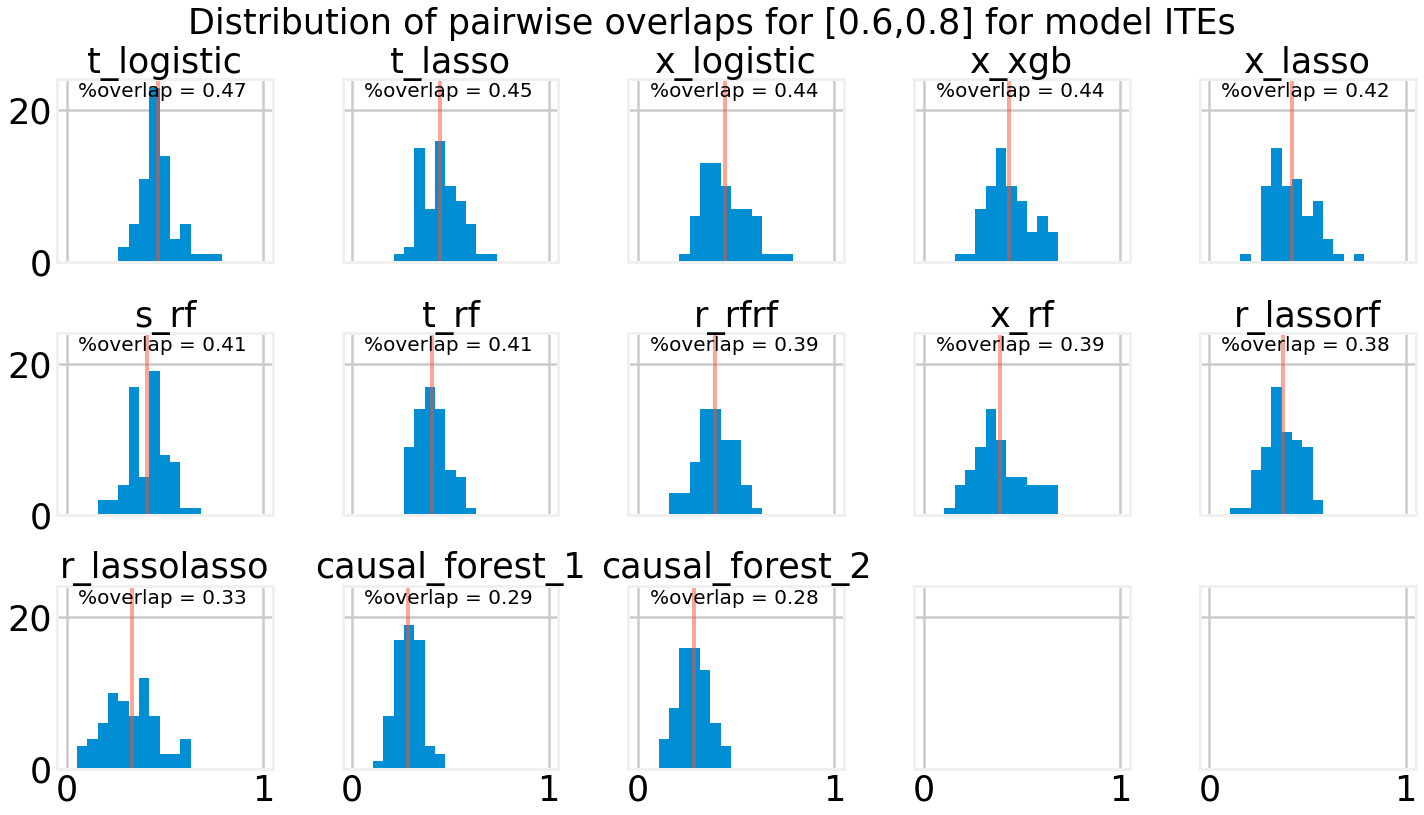

In [81]:
f, axes = plt.subplots(3, 5, figsize = [20, 11], sharex = True, sharey = True)
axes = axes.flatten()
for i, estimator in enumerate(selected_estimators):
    ax = axes[i]
    ax.hist(overlap_plot_data[estimator], bins = np.linspace(0, 1, 20))
    mean_overlap = overlap_plot_data[estimator].mean()
    ax.axvline(mean_overlap, linestyle='-', color=colors[1], alpha = 0.5)
    ax.annotate("%overlap = {:.2f}".format(mean_overlap),
                xy = (.1, .9), xycoords = ax.transAxes,
                fontsize = 20)
    ax.set_title(estimator)
#    ax.set_xticks([-2, -1, 0, 1.])
#    plt.xlim([-2, 1])
plt.tight_layout()
plt.suptitle("Distribution of pairwise overlaps for [0.6,0.8] for model ITEs", y = 1.03)
plt.show()

In [82]:
# Get data to make plot
overlap_plot_data = {}
for estimator in selected_estimators:
    overlap_plot_data[estimator] = get_overlap_values(fitted_libraries, 0, 0.2,
                                                      compare_across = "folds",
                                                      estimator = estimator)
# Order the estimators in decreasing order w.r.t. mean overlap
selected_estimators = np.array(selected_estimators)
estimator_argsort = np.argsort([-overlap_plot_data[estimator].mean() for estimator in selected_estimators])
selected_estimators = selected_estimators[estimator_argsort]

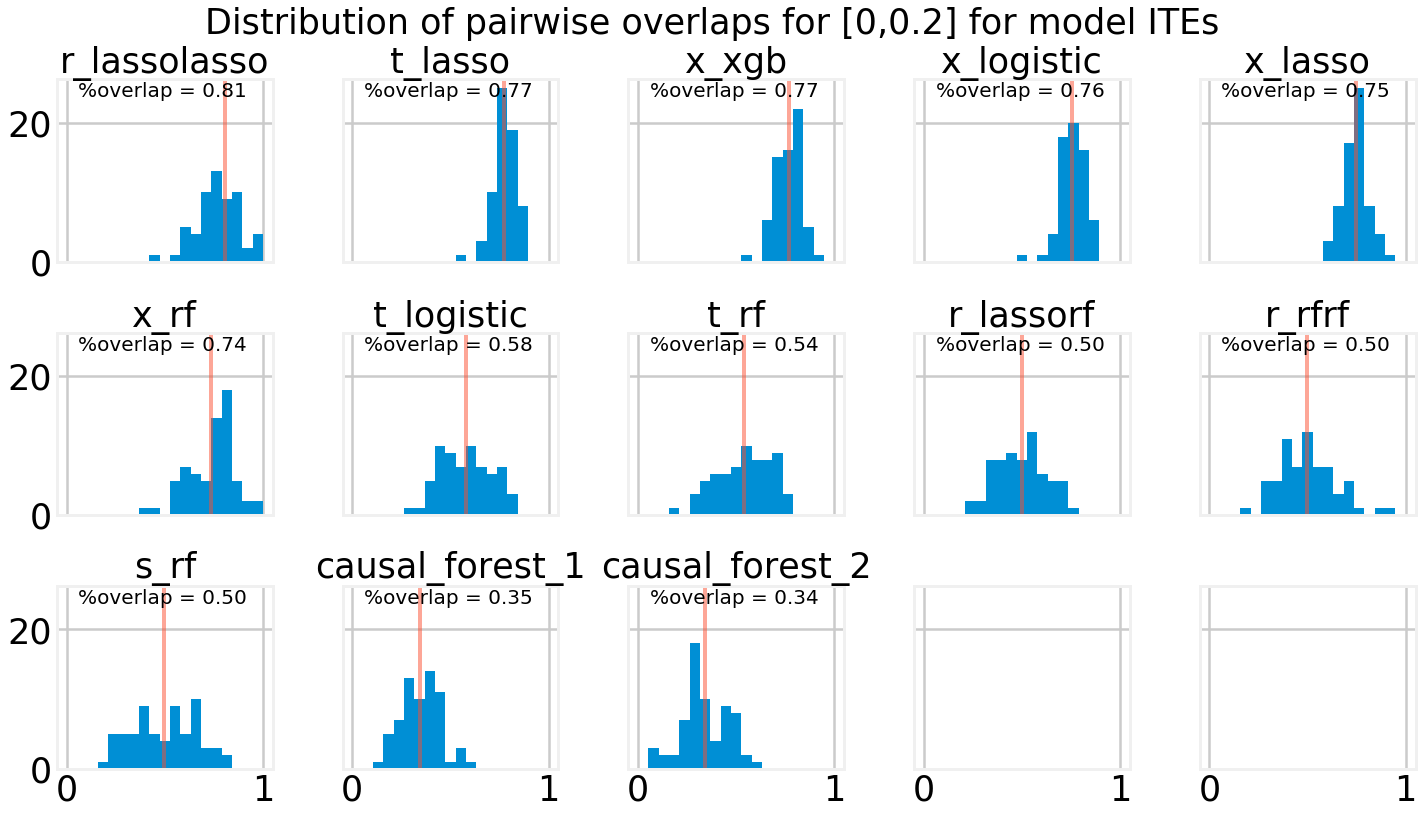

In [83]:
f, axes = plt.subplots(3, 5, figsize=[20, 11], sharex = True, sharey = True)
axes = axes.flatten()
for i, estimator in enumerate(selected_estimators):
    ax = axes[i]
    ax.hist(overlap_plot_data[estimator], bins = np.linspace(0, 1, 20))
    mean_overlap = overlap_plot_data[estimator].mean()
    ax.axvline(mean_overlap, linestyle='-', color=colors[1], alpha = 0.5)
    ax.annotate("%overlap = {:.2f}".format(mean_overlap),
                xy = (.1, .9), xycoords = ax.transAxes,
                fontsize = 20)
    ax.set_title(estimator)
#    ax.set_xticks([-2, -1, 0, 1.])
#    plt.xlim([-2, 1])
plt.tight_layout()
plt.suptitle("Distribution of pairwise overlaps for [0,0.2] for model ITEs", y = 1.03)
plt.show()

### 4.3. Aggregate correlation statistics

In [84]:
all_correlations = get_r_values(fitted_libraries, compare_across = "all", 
                                dropped_estimators = dropped_estimators)
#all_correlations = all_correlations[~np.isnan(all_correlations)] In case of nan

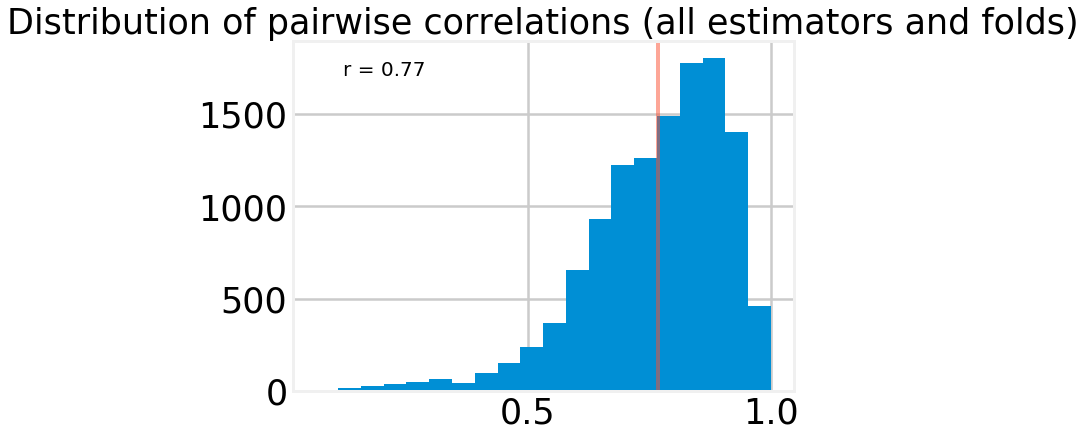

In [85]:
plt.hist(all_correlations, bins = 20, zorder = 1)
plt.title("Distribution of pairwise correlations (all estimators and folds)")
mean_r = all_correlations.mean()
plt.axvline(x = mean_r, linestyle='-', color=colors[1], alpha=0.5, zorder = 2)
ax = plt.gca()
plt.annotate("r = {:.2f}".format(mean_r),
             xy = (0.1, 0.9), xycoords = ax.transAxes,
             fontsize = 20)
plt.show()

### 4.4. Pairwise correlation for a single estimator when trained on different splits

In [86]:
marker_size = 20
alpha = 0.3

def make_model_CATE_pairplot(estimator, estimator_name = None):
    model_CATEs_df = pd.DataFrame({})
    for fold_no, result in estimator.results.items():
        model_CATEs_df[fold_no] = result.tau
    def corrfunc(x, y, **kwargs):
        r, _ = stats.pearsonr(x, y)
        ax = plt.gca()
        ax.annotate("r = {:.2f}".format(r),
                    xy = (.1, .9), xycoords = ax.transAxes,
                    fontsize = 20)
    g = sns.pairplot(model_CATEs_df, kind = "scatter", plot_kws = {"s" : marker_size,
                                                                   "alpha" : alpha})
    g = g.map_upper(corrfunc)
    g.fig.set_size_inches(15,15)
    title_string = "Pair plot for ITEs predicted by estimator when trained on 4 different folds"
    if estimator_name is not None:
        title_string += f": {estimator_name}"
    plt.suptitle(title_string, y = 1.03)
    plt.show()

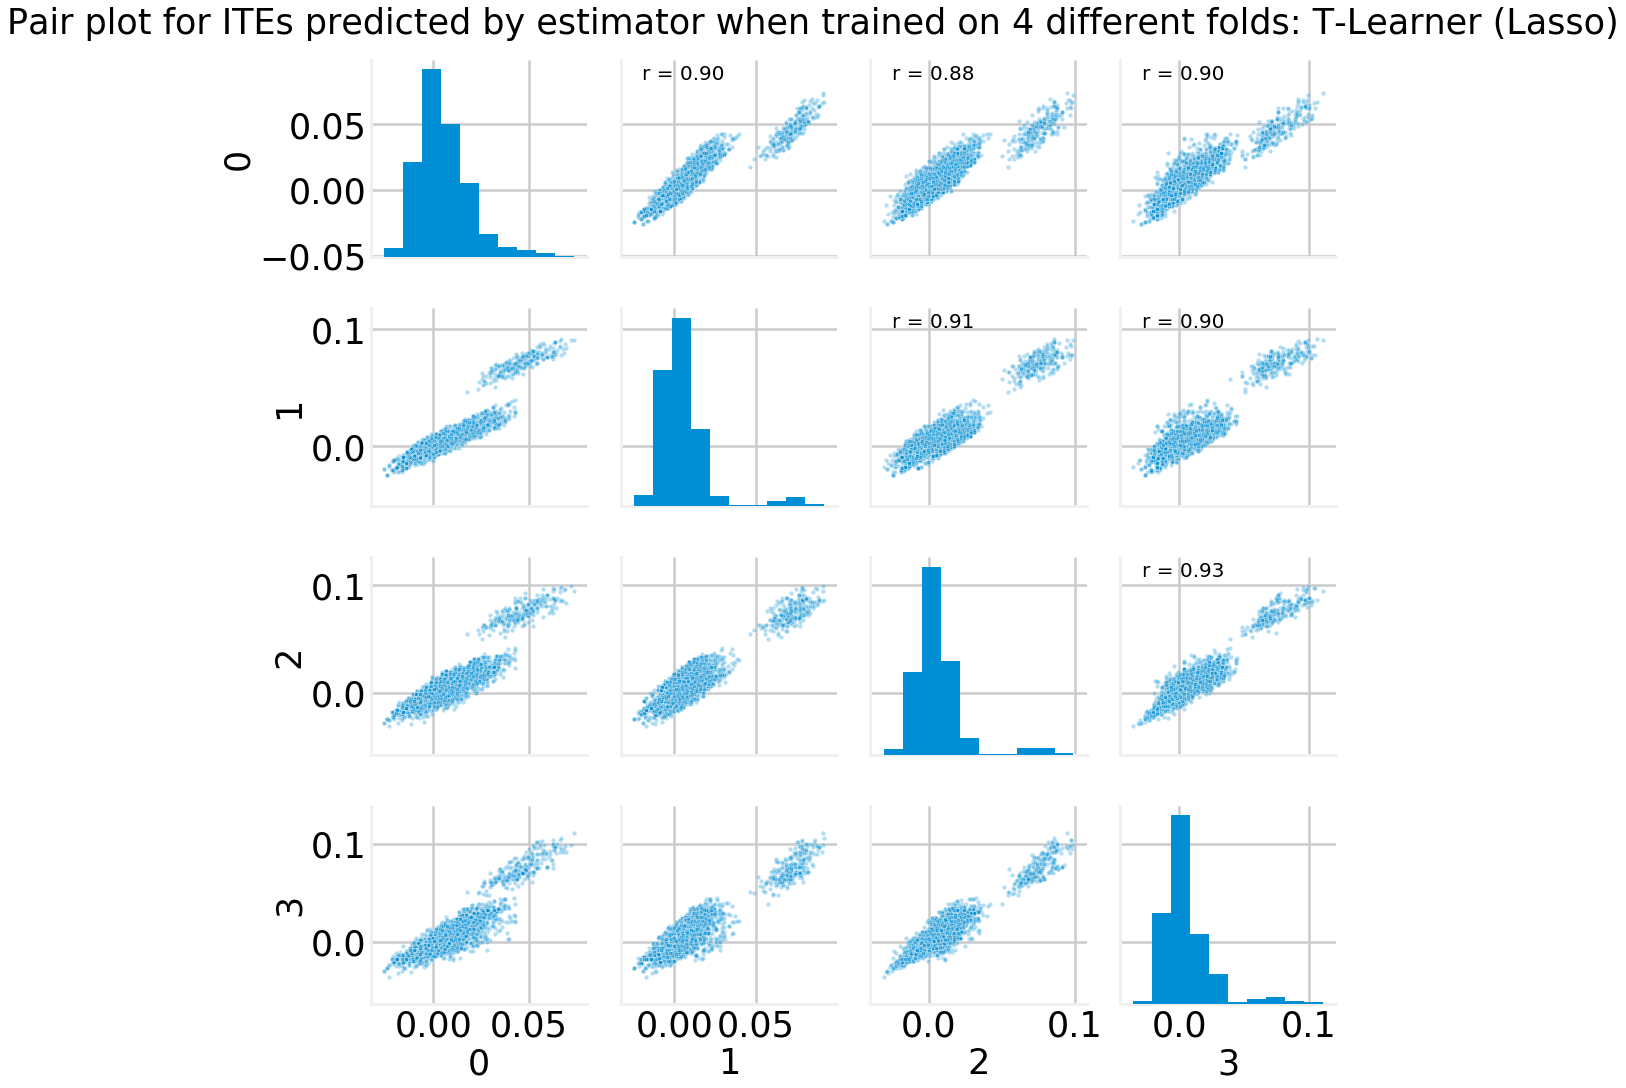

In [87]:
make_model_CATE_pairplot(fitted_libraries["pert_none"]["t_lasso"], "T-Learner (Lasso)")

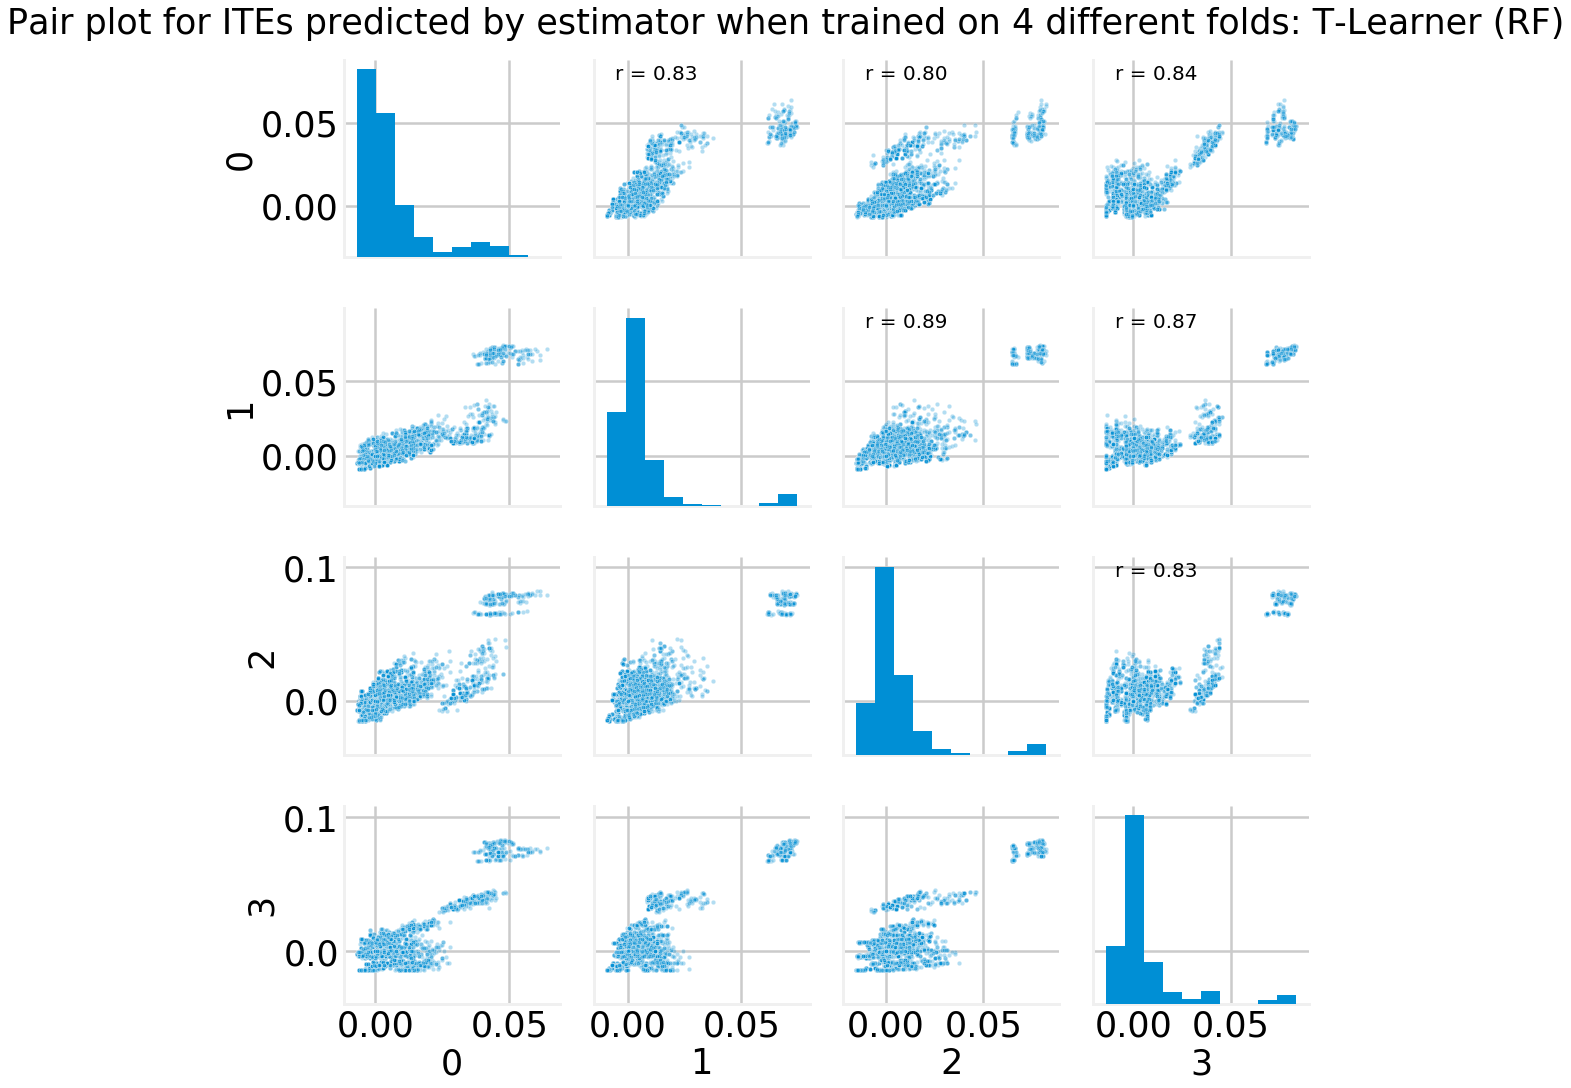

In [88]:
make_model_CATE_pairplot(fitted_libraries["pert_none"]["t_rf"], "T-Learner (RF)")

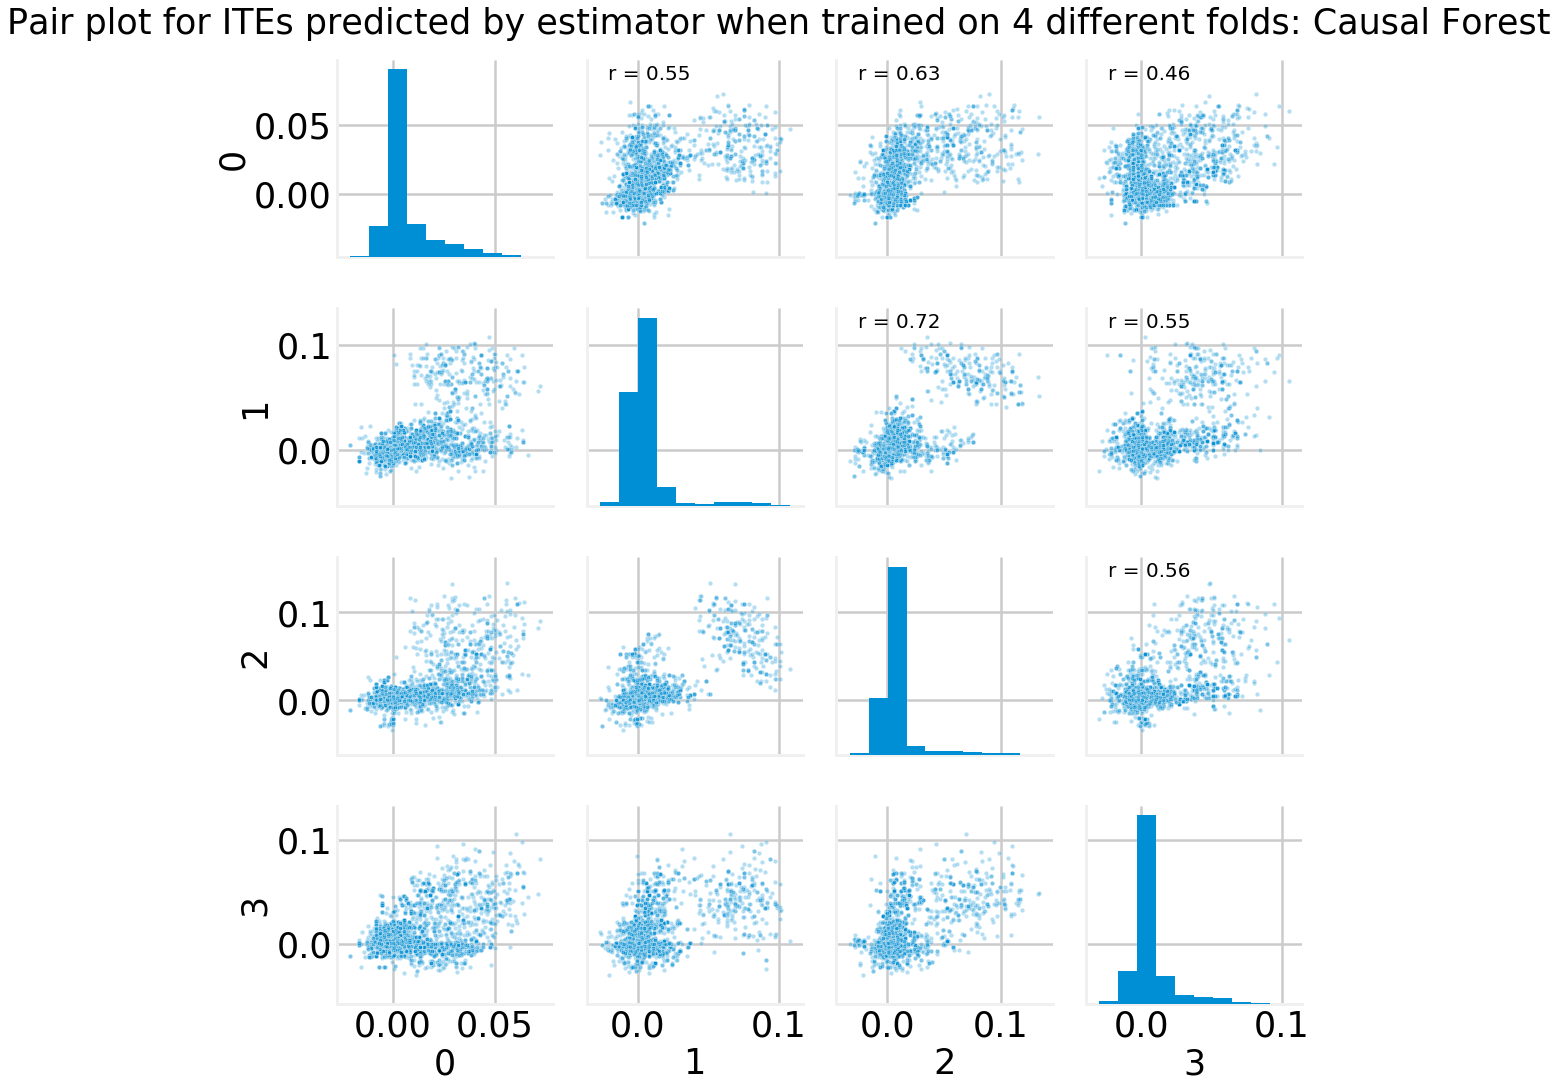

In [89]:
make_model_CATE_pairplot(fitted_libraries["pert_none"]["causal_forest_1"], "Causal Forest")